<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# Data Exploration

The most optimized data pipelines are built by being intimate with the features and characteristics of our data. This notebook covers statistical techniques to quickly identify anomalies.

## Objectives

* Learn how to use summary statistics and visualization to build a "sense" of the data
* Learn how to deal with outliers and missing data

For these notebooks, we will be using <a href="https://www.noaa.gov/">NOAA's</a> Hourly Precipitation Data. It goes all the way back to 1940! We will be using an unmodified version of their data pulled straight from their database <a href="https://www.ncei.noaa.gov/data/coop-hourly-precipitation/v2/archive/">here</a>. 

NOAA has a number of <a href="https://www.ncdc.noaa.gov/data-access/quick-links">famous datasets</a> for the amateur and professional meteorologist. We have already downloaded the <a href="https://www.gnu.org/software/tar/manual/html_node/Standard.html">tarball</a> file into the `data` folder and decompressed it with the following command:

`tar -xvzf HPD_v02r02_POR_s19400101_e20210304_c20210310.tar.gz -C data;`

Feel free to open one of the csv files to look at it directly. We can also load it into <a href="https://docs.rapids.ai/api/cudf/stable/">cuDF</a> in order to run some analysis on it.

In [4]:
import cudf

aqc_df = cudf.read_csv("data/AQC00914594.csv")
aqc_df.head()

,STATION,LATITUDE,LONGITUDE,ELEVATION,DATE,ELEMENT,HR00Val,HR00MF,HR00QF,HR00S1,...,HR23Val,HR23MF,HR23QF,HR23S1,HR23S2,DlySum,DlySumMF,DlySumQF,DlySumS1,DlySumS2
0,AQC00914594,-14.3333,-170.767,42.4,2019-09-29,HPCP,-9999,0,0,H,...,-9999,0,0,H,,0,0,P,0,C
1,AQC00914594,-14.3333,-170.767,42.4,2020-06-10,HPCP,-9999,0,0,H,...,0,0,0,H,C,2,0,P,0,C
2,AQC00914594,-14.3333,-170.767,42.4,2020-06-12,HPCP,0,0,0,H,...,0,0,0,H,C,22,0,,0,C
3,AQC00914594,-14.3333,-170.767,42.4,2020-06-13,HPCP,0,0,0,H,...,0,0,0,H,C,10,0,,0,C
4,AQC00914594,-14.3333,-170.767,42.4,2020-06-14,HPCP,0,0,0,H,...,0,0,0,H,C,0,0,P,0,C


Let's take a look at the <a href="https://www.ncei.noaa.gov/data/coop-hourly-precipitation/v2/doc/readme.csv.txt">NOAA documentation</a> for this dataset. In particular, section "IV.  FORMAT OF HPD .csv DATA FILES:" describes the format of the data above.

After reading through the documentation and building an understanding of the above data, click the `...` below to compare your notes with ours.

### Key Takeaways

* Each row represents a day's precipitation at a Hourly Precipitation Data (HPD) Station.
 * Precipitation is measured in hundredths of an inch
* Each hour is represented as a column with HR00 being the first hour of the day and HR23 being the last.
 * A missing value is represented as -9999
* Each hour has a number of flags describing its source and the quality of measurement (MF, QF, S1, S2).
* The last few columns are the daily sum across the hours in their respective rows.
 * A `P` in the DlySum Quality column (QF) represents a partial sum where some of the hours had missing data.
* Currently, there is only one element type, meaning we can ignore this column.

## Data Cleansing

Looks like NOAA already has some good quality control, but what about those `-9999`s? If we keep them in, they'll mess up any calculations or visualizations we make. Let's take a look at what we mean by creating a <a href="https://plotly.com/python/histograms/">histogram</a>. Histograms are useful because it allows us to see the distribution of our dataset. It can answer questions like:

* What is the range (the minimum and the maximum)?
* What is the spread?
 * Is it evenly distributed across the range or are certain values more common than others?
* Is the data skewed (is it more concentrated on the right side or the left)?

However, when there are uncleaned values, this can quickly remove the usefulness of these graphs. Let's take a look using <a href="https://plotly.com/python/histograms/#histograms-with-gohistogram">Plotly Graph Objects</a>. Plotly can't directly access data stored on the GPU, so we'll bring it back to the host with <a href="https://docs.rapids.ai/api/cudf/stable/api.html?highlight=to_array#cudf.core.series.Series.to_array">to_array</a>.

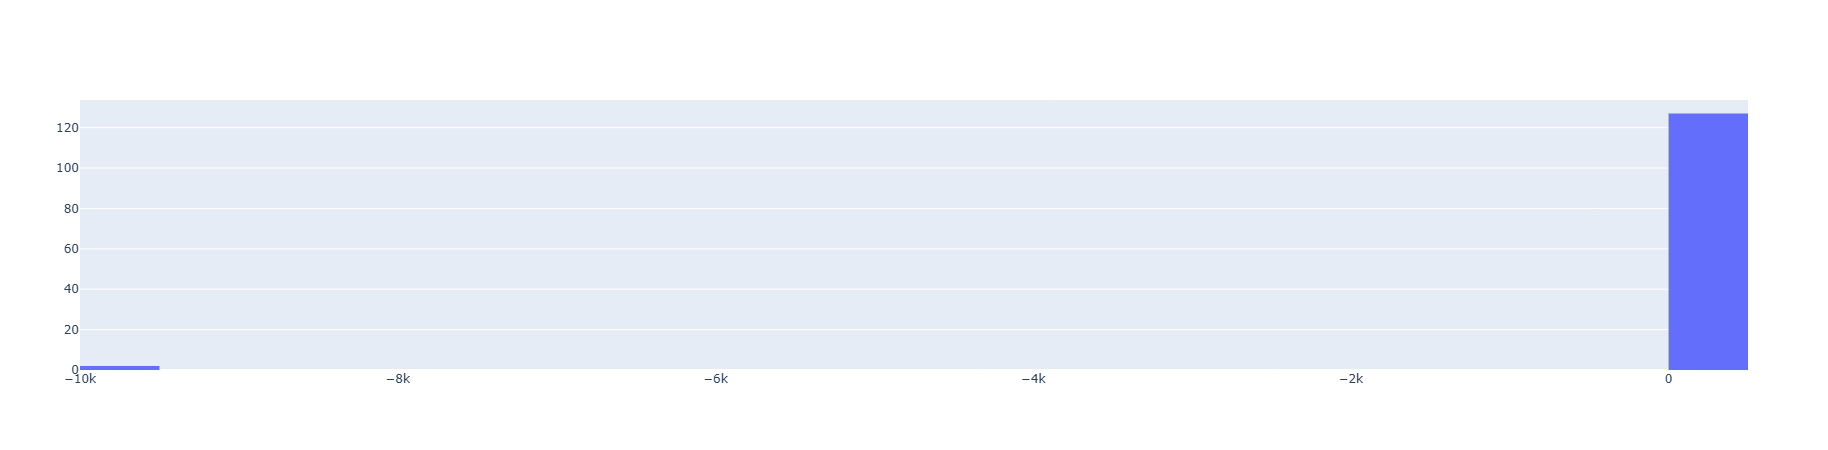

In [5]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Histogram(x=aqc_df["HR00Val"].to_array())])
fig.show()

Here, the `-9999`s have such a large magnitude compared to the other values, that we only end up with two not very useful buckets. Before we get to plotting, we can use the <a href="https://docs.rapids.ai/api/cudf/stable/api.html?highlight=describe#cudf.core.dataframe.DataFrame.describe">describe</a> method in order to quickly catch unusual data.

It will compute the following for all columns:
* count - the number of cells with a value
* <a href="https://en.wikipedia.org/wiki/Average">mean</a> - the average across all the cells with a value
* <a href="https://en.wikipedia.org/wiki/Standard_deviation">std</a> - a measure of the variation of the data
* min - the minimum (smallest) value across all cells in a column
* 25% - the first <a href="https://en.wikipedia.org/wiki/Quartile">quartile</a>, which is a type of <a href="https://en.wikipedia.org/wiki/Quantile">quantile</a>. It can be calculated as the median between the minimum value and the median.
* 50% - the <a href="https://en.wikipedia.org/wiki/Median">median</a>. If all values are ordered, this is the value in the middle.
* 75% - the third quartile, or the median between the median and the maximum value.
* max - the maximum (largest) value across all cells in a column 

Run the code cell below, and try to answer the following questions:
* Where does the `-9999` show up in the summary?
* Besides the min, what other statistics does it impact?
* Any other unusual observations about the data?

In [3]:
aqc_df.describe()

,LATITUDE,LONGITUDE,ELEVATION,HR00Val,HR00MF,HR00QF,HR01Val,HR01MF,HR01QF,HR02Val,...,HR21QF,HR22Val,HR22MF,HR22QF,HR23Val,HR23MF,HR23QF,DlySum,DlySumMF,DlySumS1
count,129.0000,129.000,129.0,129.000000,129.0,129.0,129.000000,129.0,129.0,129.000000,...,129.0,129.000000,129.0,129.0,129.000000,129.0,129.0,129.000000,129.0,129.0
mean,-14.3333,-170.767,42.4,-153.720930,0.0,0.0,-153.527132,0.0,0.0,-153.736434,...,0.0,-231.170543,0.0,0.0,-154.387597,0.0,0.0,59.573643,0.0,0.0
std,0.0000,0.000,0.0,1240.320989,0.0,0.0,1240.352238,0.0,0.0,1240.322529,...,0.0,1513.109635,0.0,0.0,1240.234185,0.0,0.0,112.574821,0.0,0.0
min,-14.3333,-170.767,42.4,-9999.000000,0.0,0.0,-9999.000000,0.0,0.0,-9999.000000,...,0.0,-9999.000000,0.0,0.0,-9999.000000,0.0,0.0,0.000000,0.0,0.0
25%,-14.3333,-170.767,42.4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
50%,-14.3333,-170.767,42.4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,7.000000,0.0,0.0
75%,-14.3333,-170.767,42.4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,47.000000,0.0,0.0
max,-14.3333,-170.767,42.4,31.000000,0.0,0.0,54.000000,0.0,0.0,56.000000,...,0.0,93.000000,0.0,0.0,40.000000,0.0,0.0,537.000000,0.0,0.0


Anwers ready? Click the `...` below to compare with our answers.

* <b>Where does the `-9999` show up in the summary?</b>
 * The -9999 appears in the minimum. This should be a red flag to us because how is negative rainfall possible?
* <b>Besides the min, what other statistics does it impact?</b>
 * This strongly affects the mean as the -9999 has a much larger magnitude than the other precipitation data
 * It also strongly affects the standard deviation as it is based on the range between the minimum and maximum values
* <b>Any other unusual observations about the data?</b>
 * For some columns like latitude and longitude, the standard deviation is `0`. That means all cells in a column have the same value. If we were only working with this .csv, this would be a waste of space, but this value changes depending on the .csv, so we'll keep it as is.
 * Non-numerical columns will still have statistics computed for them, although the results don't have much meaning.

Thankfully, there is a straightforward way to fix this. As we are reading in the data, we can let <a href="https://docs.rapids.ai/api/cudf/stable/api.html?highlight=read_csv#cudf.io.csv.read_csv">cudf.read_csv</a> know that we want to treat `-9999` as a missing value with the `na_values` parameter.

In [6]:
aqc_df = cudf.read_csv('data/AQC00914594.csv', na_values=['-9999'])
aqc_df.head()

,STATION,LATITUDE,LONGITUDE,ELEVATION,DATE,ELEMENT,HR00Val,HR00MF,HR00QF,HR00S1,...,HR23Val,HR23MF,HR23QF,HR23S1,HR23S2,DlySum,DlySumMF,DlySumQF,DlySumS1,DlySumS2
0,AQC00914594,-14.3333,-170.767,42.4,2019-09-29,HPCP,<NA>,0,0,H,...,<NA>,0,0,H,,0,0,P,0,C
1,AQC00914594,-14.3333,-170.767,42.4,2020-06-10,HPCP,<NA>,0,0,H,...,0.0,0,0,H,C,2,0,P,0,C
2,AQC00914594,-14.3333,-170.767,42.4,2020-06-12,HPCP,0.0,0,0,H,...,0.0,0,0,H,C,22,0,,0,C
3,AQC00914594,-14.3333,-170.767,42.4,2020-06-13,HPCP,0.0,0,0,H,...,0.0,0,0,H,C,10,0,,0,C
4,AQC00914594,-14.3333,-170.767,42.4,2020-06-14,HPCP,0.0,0,0,H,...,0.0,0,0,H,C,0,0,P,0,C


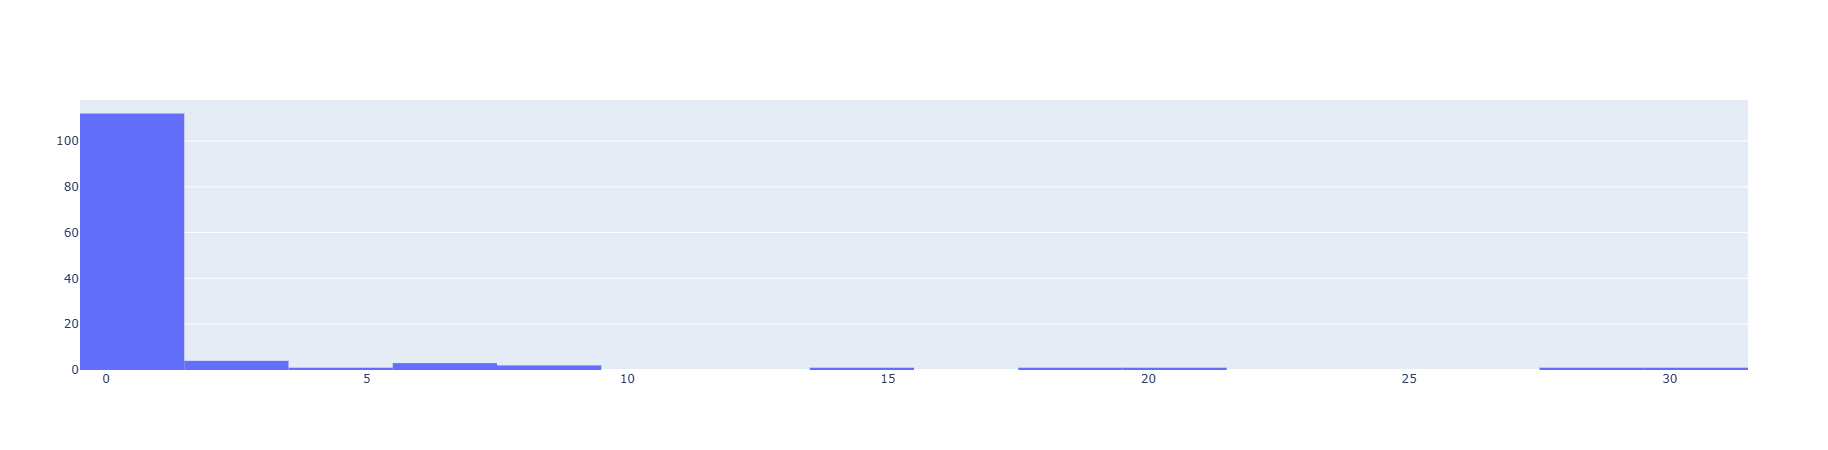

In [7]:
fig = go.Figure(data=[go.Histogram(x=aqc_df["HR00Val"].to_array())])
fig.show()

Much better! Let's take a look at our summary statistics again to see how the values change.

In [8]:
aqc_df.describe()

,LATITUDE,LONGITUDE,ELEVATION,HR00Val,HR00MF,HR00QF,HR01Val,HR01MF,HR01QF,HR02Val,...,HR21QF,HR22Val,HR22MF,HR22QF,HR23Val,HR23MF,HR23QF,DlySum,DlySumMF,DlySumS1
count,129.0000,129.000,129.0,127.000000,129.0,129.0,127.000000,129.0,129.0,127.000000,...,129.0,126.000000,129.0,129.0,127.000000,129.0,129.0,129.000000,129.0,129.0
mean,-14.3333,-170.767,42.4,1.322835,0.0,0.0,1.519685,0.0,0.0,1.307087,...,0.0,1.396825,0.0,0.0,0.645669,0.0,0.0,59.573643,0.0,0.0
std,0.0000,0.000,0.0,4.688523,0.0,0.0,6.261308,0.0,0.0,5.548504,...,0.0,8.757241,0.0,0.0,3.857640,0.0,0.0,112.574821,0.0,0.0
min,-14.3333,-170.767,42.4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
25%,-14.3333,-170.767,42.4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
50%,-14.3333,-170.767,42.4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,7.000000,0.0,0.0
75%,-14.3333,-170.767,42.4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,47.000000,0.0,0.0
max,-14.3333,-170.767,42.4,31.000000,0.0,0.0,54.000000,0.0,0.0,56.000000,...,0.0,93.000000,0.0,0.0,40.000000,0.0,0.0,537.000000,0.0,0.0


Most hours of the day, there is no precipitation, hence why there is a fat stack above the `0`. Let's drop those zeros in order to see if when it rains, it pours.

**TODO**: Replace the `FIXME` to select only values greater than `0` from the `HR00Val` column. Check the <a href="https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html">pandas documentation</a> for a hint.

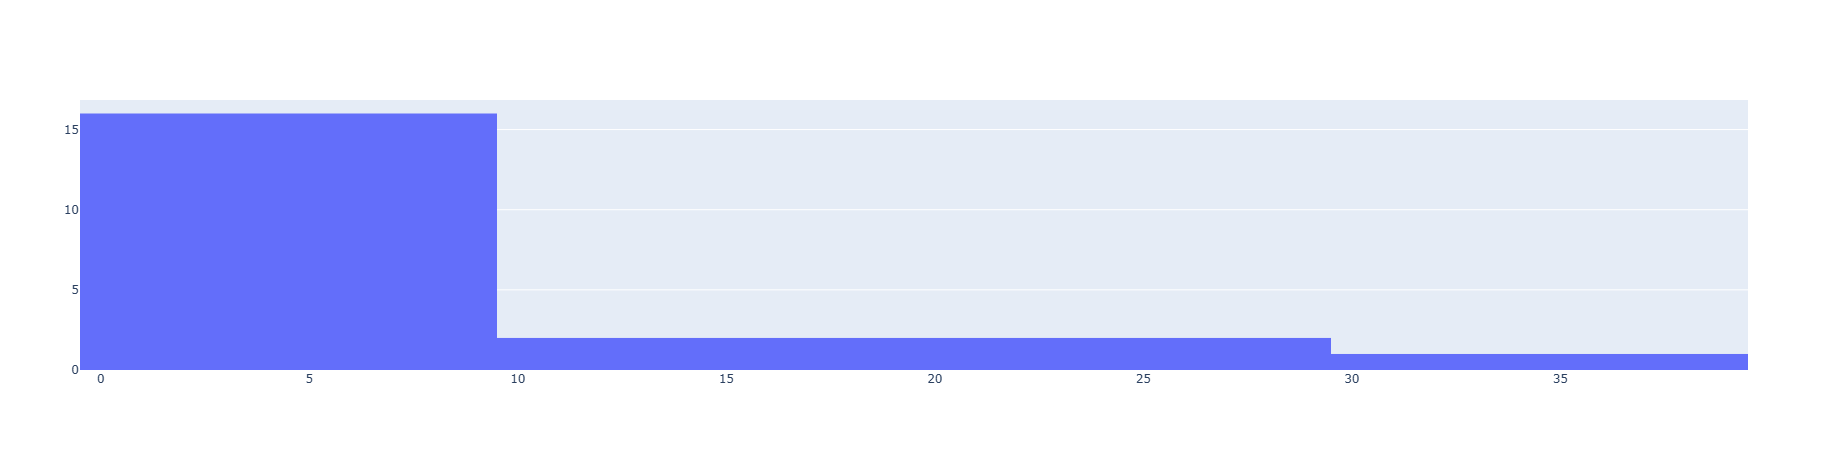

In [9]:
aqc_df_filtered = aqc_df[aqc_df["HR00Val"]>0]
x = aqc_df_filtered["HR00Val"].to_array()
fig = go.Figure(data=[go.Histogram(x=x)])
fig.show()

In [ ]:
aqc_df_filtered = aqc_df[aqc_df["HR00Val"] > 0]
x = aqc_df_filtered["HR00Val"].to_array()
fig = go.Figure(data=[go.Histogram(x=x)])
fig.show()

Let's take a look at the summary one more time to see how things have changed.

In [10]:
aqc_df_filtered.describe()

,LATITUDE,LONGITUDE,ELEVATION,HR00Val,HR00MF,HR00QF,HR01Val,HR01MF,HR01QF,HR02Val,...,HR21QF,HR22Val,HR22MF,HR22QF,HR23Val,HR23MF,HR23QF,DlySum,DlySumMF,DlySumS1
count,21.0000,21.000,21.0,21.000000,21.0,21.0,21.000000,21.0,21.0,21.000000,...,21.0,21.000000,21.0,21.0,21.000000,21.0,21.0,21.000000,21.0,21.0
mean,-14.3333,-170.767,42.4,8.000000,0.0,0.0,7.047619,0.0,0.0,2.761905,...,0.0,5.142857,0.0,0.0,0.428571,0.0,0.0,150.000000,0.0,0.0
std,0.0000,0.000,0.0,9.077445,0.0,0.0,13.219214,0.0,0.0,4.241518,...,0.0,20.328024,0.0,0.0,1.247855,0.0,0.0,138.740405,0.0,0.0
min,-14.3333,-170.767,42.4,1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,8.000000,0.0,0.0
25%,-14.3333,-170.767,42.4,1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,40.000000,0.0,0.0
50%,-14.3333,-170.767,42.4,4.000000,0.0,0.0,1.000000,0.0,0.0,1.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,106.000000,0.0,0.0
75%,-14.3333,-170.767,42.4,9.000000,0.0,0.0,7.000000,0.0,0.0,6.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,201.000000,0.0,0.0
max,-14.3333,-170.767,42.4,31.000000,0.0,0.0,54.000000,0.0,0.0,16.000000,...,0.0,93.000000,0.0,0.0,5.000000,0.0,0.0,493.000000,0.0,0.0


Now our data is starting to look much more interesting. How do we scale this to all of our .csv files?

Unfortunately, cuDF is not made to read and digest multiple .csv files at once. We could load each .csv one at a time, but, spoiler alert, it's going to be very slow and may even crash our GPU instance. The cell below counts the number of .csv files in our `data` folder.

In [11]:
ls -l data | wc -l

1992


Over 1900 files! In the next notebook, we'll learn how to ingest all of these quickly using <a href="https://dask.org/">Dask</a>.

In [12]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>